In [73]:
import numpy as np
from math import log

def log2(val):
    return log(val, 2)

# print a matrix for latex
def latex_matrix(A):
    for row in A:
        for ele in row[:-1]:
            print(ele, end=' & ')
        print(row[-1], end=' \\\\\n')

# pretty print for np.array 
# from https://stackoverflow.com/questions/53126305/pretty-printing-numpy-ndarrays-using-unicode-characters/53164538#53164538
def pretty_print(A):
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c' + u'\u2500' * w + u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i, AAA in enumerate(AA[:-1]):
                w1 = max([len(str(s)) for s in A[:, i]])
                print(str(AAA) + ' ' * (w1  - len(str(AAA)) + 1), end='')
            w1 = max([len(str(s)) for s in A[  :, -1]])
            print(str(AA[-1]) + ' ' * (w1 - len(str(AA[-1]))), end='')
            print(']')
        print(u'\u2514'+u'\u2500' * w + u'\u2518')  

def compare(left: set, right: set):
    if len(left) == len(right):
        for i in range(len(left)):
            if left[i] != right[i]:
                return left[i] < right[i]
    return left < right


### Generate $\mathcal{A}_n^2$

> Let $|\cdot|$ denotes cardinality and $\Delta$ denote symmetric different

In [74]:
def Delta(left: set, right: set):
    return left.symmetric_difference(right)

def Cardi(x: set):
    return len(x)

> Let $n=2^m$, $\Omega$ be a set of $m$ element such that $|\alpha_i| \leq |\alpha_{i+1}|$ and $|\alpha_i \Delta \alpha_{i+1}| \leq 2$  
> Let $\alpha_0=\{\varnothing\}$, now genereate $\Omega$

> utils func for checking $|\alpha_i| \leq |\alpha_{i+1}|$ and $|\alpha_i \Delta \alpha_{i+1}| \leq 2$  

In [75]:
def legal(alpha_i: set, alpha_i_1: set):
    return Cardi(alpha_i) <= Cardi(alpha_i_1) and Cardi(Delta(alpha_i, alpha_i_1)) <= 2

def assert_omega(ome, _m, skip=0):
    for i in range(0 + skip, len(ome) - 1):
        if not legal(ome[i], ome[i + 1]):
            print(ome[i], ome[i + 1])
        assert(legal(ome[i], ome[i + 1]))
    assert(len(ome) == 2**_m + 1)

In [76]:
from itertools import chain, combinations

# generate Omega
def insert_one_element(initial_sets: list, super_end: int) -> list:
    res = []
    for initial_set in initial_sets:
        avail_range = list(range(max(initial_set) + 1, super_end + 1))
        if len(avail_range) == 0:
            continue
        if len(res) == 0 and avail_range[0] not in initial_sets[-1]:
            avail_range.reverse()
        elif len(res) != 0 and avail_range[0] not in res[-1]:
            avail_range.reverse()
        for avail_ele in avail_range:
            if avail_ele in initial_set:
                break
            cur_res = initial_set.copy()
            cur_res.add(avail_ele)
            res.append(cur_res)
    
    return res

def create_Omega(_m: int):
    initial_sets = [{i + 1} for i in range(_m)]
    grouped_res = [initial_sets]
    for _ in range(1, _m):
        grouped_res.append(insert_one_element(grouped_res[-1], _m))

    res = [set(), set()]
    for single_res in  grouped_res:
        res.extend(single_res)
    ### the follow code is for verification
    s = list(range(1, _m + 1))
    unoredered = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    for ele in unoredered:
        assert(set(ele) in res)
    assert(len(unoredered) == len(res) - 1)
    assert_omega(res, _m)
    ### verification ends
    return res


In [77]:
# test
_test_m = 4
_test_omega = create_Omega(_test_m)
_test_omega

[set(),
 set(),
 {1},
 {2},
 {3},
 {4},
 {1, 4},
 {1, 3},
 {1, 2},
 {2, 4},
 {2, 3},
 {3, 4},
 {1, 3, 4},
 {1, 2, 3},
 {1, 2, 4},
 {2, 3, 4},
 {1, 2, 3, 4}]

> now that we have $\Omega = [a_{0}, a_{1}, ..., a_{k}]$, we can generate $A=\{\alpha_{ij}\} \in \mathcal{A}_n^2$ by:  
> $$a_{ij} = \begin{cases}
    -1,\;\alpha_j\bigcap(\alpha_{i-1}\bigcup\alpha_i)=\alpha_{i-1}\Delta\alpha_{i}\;and\;|\alpha_{i-1}\Delta\alpha_{i}|=2 \\
    (-1)^{|\alpha_{i-1}\bigcap\alpha_j| + 1},\;\alpha_{j}\bigcap(\alpha_{i-1}\bigcup\alpha_{i})\neq\varnothing\;but\;does\;not\;meet\;the\;condition\;above \\
    1,\;\alpha_j\bigcap(\alpha_{i-1}\bigcup\alpha_i)=\varnothing \\
\end{cases}
$$

In [78]:
def query_element(i: int, j: int, _omega: list) -> int:
    alpha_j = _omega[j + 1]
    alpha_i_1 = _omega[i]
    alpha_i = _omega[i + 1]

    if alpha_j.intersection(alpha_i_1.union(alpha_i)) == Delta(alpha_i_1, alpha_i) \
        and Cardi(Delta(alpha_i_1, alpha_i)) == 2:
        return -1
    elif Cardi(alpha_j.intersection(alpha_i_1.union(alpha_i))) != 0:
        return (-1)**(Cardi(alpha_i_1.intersection(alpha_j)) + 1)
    elif Cardi(alpha_j.intersection(alpha_i_1.union(alpha_i))) == 0:
        return 1
    else:
        raise ValueError("Undefined behavior!")
    
def create_A(_omega, _m):
    A_mat = np.zeros((2**_m, 2**_m))
    for i in range(A_mat.shape[0]):
        for j in range(A_mat.shape[1]):
            A_mat[i, j] = query_element(i, j, _omega)
    return A_mat

In [79]:
# test
A_mat = create_A(_test_omega, _test_m)
pretty_print(A_mat.astype(int))

┌─────────────────────────────────────────────────┐
 [1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 ]
 [1 -1 1  1  1  -1 -1 -1 1  1  1  -1 -1 -1 1  -1]
 [1 1  -1 1  1  1  1  -1 -1 -1 1  1  -1 -1 -1 -1]
 [1 1  1  -1 1  1  -1 1  1  -1 -1 -1 -1 1  -1 -1]
 [1 1  1  1  -1 -1 1  1  -1 1  -1 -1 1  -1 -1 -1]
 [1 -1 1  1  1  1  -1 -1 1  1  1  1  -1 1  1  1 ]
 [1 1  1  -1 1  -1 1  1  1  -1 -1 -1 1  -1 -1 -1]
 [1 1  -1 1  1  1  -1 1  -1 -1 1  -1 -1 1  -1 -1]
 [1 1  1  1  -1 -1 1  -1 1  1  -1 -1 -1 -1 1  -1]
 [1 1  1  -1 1  1  -1 1  -1 1  -1 -1 1  -1 -1 -1]
 [1 1  1  1  -1 -1 1  1  -1 -1 1  1  -1 -1 -1 -1]
 [1 -1 1  1  1  1  1  -1 1  1  -1 -1 1  1  -1 -1]
 [1 1  -1 1  1  -1 -1 1  -1 1  -1 1  -1 -1 -1 1 ]
 [1 1  1  1  -1 1  -1 -1 1  -1 -1 -1 1  -1 -1 1 ]
 [1 1  1  -1 1  -1 -1 -1 -1 1  1  -1 -1 1  -1 1 ]
 [1 -1 1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 1  1 ]
└─────────────────────────────────────────────────┘


### Check $A = LQ$

> Let $Q$ be a $n$ by $n$ matrix given by $q_{ij} = (-1)^{|\alpha_i \bigcap \alpha_j|}$, $Q$ is a symmetric Hadamard matrix, that is $Q^2=QQ^T=nI_n$  
> now we check if $Q$ is a symmetric Hadamard matrix  

In [80]:
def get_Q(_omega, _n):
    Q_mat = np.zeros((_n, _n))
    for i in range(_n):
        for j in range(_n):
            Q_mat[i, j] = (-1) ** Cardi(_omega[i + 1].intersection(_omega[j + 1]))
    return np.matrix(Q_mat)

Q_mat = get_Q(_test_omega, 2**_test_m)
pretty_print(np.array((Q_mat).astype(int)))
pretty_print(np.array((Q_mat * Q_mat).astype(int)))

┌─────────────────────────────────────────────────┐
 [1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 ]
 [1 -1 1  1  1  -1 -1 -1 1  1  1  -1 -1 -1 1  -1]
 [1 1  -1 1  1  1  1  -1 -1 -1 1  1  -1 -1 -1 -1]
 [1 1  1  -1 1  1  -1 1  1  -1 -1 -1 -1 1  -1 -1]
 [1 1  1  1  -1 -1 1  1  -1 1  -1 -1 1  -1 -1 -1]
 [1 -1 1  1  -1 1  -1 -1 -1 1  -1 1  -1 1  -1 1 ]
 [1 -1 1  -1 1  -1 1  -1 1  -1 -1 1  1  -1 -1 1 ]
 [1 -1 -1 1  1  -1 -1 1  -1 -1 1  -1 1  1  -1 1 ]
 [1 1  -1 1  -1 -1 1  -1 1  -1 -1 -1 -1 1  1  1 ]
 [1 1  -1 -1 1  1  -1 -1 -1 1  -1 -1 1  -1 1  1 ]
 [1 1  1  -1 -1 -1 -1 1  -1 -1 1  1  -1 -1 1  1 ]
 [1 -1 1  -1 -1 1  1  -1 -1 -1 1  -1 1  1  1  -1]
 [1 -1 -1 -1 1  -1 1  1  -1 1  -1 1  -1 1  1  -1]
 [1 -1 -1 1  -1 1  -1 1  1  -1 -1 1  1  -1 1  -1]
 [1 1  -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  -1 -1]
 [1 -1 -1 -1 -1 1  1  1  1  1  1  -1 -1 -1 -1 1 ]
└─────────────────────────────────────────────────┘
┌─────────────────────────────────────────────────┐
 [16 0  0  0  0  0  0  0  0  0  0  0  0  0  

> And verify matrix $L = AQ^{-1}$ is a lower triangular matrix

In [81]:
pretty_print(np.array(np.matrix(A_mat) * np.matrix(Q_mat).I))

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
 [1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.5   0.5   0.0   0.0   -0.5  0.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.0   0.0   0.5   0.5   -0.5  0.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.0   0.5   0.5   0.0   0.0   -0.5  0.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ]
 [0.0   0.5   0.0   0.0   0.5   0.0   0.0   -0.5  0.5   0.0   0.0   0.0   0.0   0.0

### Generate $\mathcal{A}_{n - 1}^1$

> Let $B\in\mathcal{A}_{n - 1}^1$, $\Phi(B)\in\mathcal{A}_{n}^2\;$:
> $$ \Phi(B) = \left(\begin{array}{cc} 
1 & 1_{n-1}\\
-1^T_{n-1} & 2B-J_{n-1}
\end{array}\right)
> $$
>
> notice that the $A_2 \in \mathcal{A}_n^2$ we have has it's first column as:
> $$ A_2 = \Phi(B) = \left(\begin{array}{cc} 
1\\
1^T_{n-1}
\end{array}\right)
> $$
> we need to multiply $\{\alpha_{ij}\}_{2\le i\le n, 2\le j\le n} \in \mathcal{A}_n^2$ with $-1$  
> so we can generate matrix $A_1 \in \mathcal{A}_{n - 1}^1$ with $A_2 = \{\alpha_{ij}\} \in \mathcal{A}_n^2$ using the following relation:    
> $$A_1 = \frac{1}{2}(J_{n-1}-\{\alpha_{ij}\}_{2\le i\le n, 2\le j\le n})$$

In [82]:
def create_A_1_mat(A_2_mat):
    
    A_1_mat = (np.ones(A_2_mat.shape[0] - 1) - A_2_mat[1:, 1:]) * 0.5
    assert((A_1_mat.max() == 1 and A_1_mat.min() == 0) if A_1_mat.shape[0] > 1 else True)
    return A_1_mat


In [83]:
# test
pretty_print(create_A_1_mat(A_mat).astype(int))

┌───────────────────────────────┐
 [1 0 0 0 1 1 1 0 0 0 1 1 1 0 1]
 [0 1 0 0 0 0 1 1 1 0 0 1 1 1 1]
 [0 0 1 0 0 1 0 0 1 1 1 1 0 1 1]
 [0 0 0 1 1 0 0 1 0 1 1 0 1 1 1]
 [1 0 0 0 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 1 1 1 0 1 1 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 0 1 1]
 [0 0 0 1 1 0 1 0 0 1 1 1 1 0 1]
 [0 0 1 0 0 1 0 1 0 1 1 0 1 1 1]
 [0 0 0 1 1 0 0 1 1 0 0 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 1 1 0 0 1 1]
 [0 1 0 0 1 1 0 1 0 1 0 1 1 1 0]
 [0 0 0 1 0 1 1 0 1 1 1 0 1 1 0]
 [0 0 1 0 1 1 1 1 0 0 1 1 0 1 0]
 [1 0 0 0 0 0 0 1 1 1 1 1 1 0 0]
└───────────────────────────────┘


In [84]:
def funcX(A):
    return np.absolute(np.matrix(A).I).max()

def get_o_1(_X, _n):
    expon = 0.5 * _n * log2(_n) - 2 * _n
    return 2**expon, (expon - log2(_X)) / _n

### Verify $χ(A)=2^{\frac{1}{2}nlogn - n(1+o(1))}$
> with $χ(A) = max_{i, j}|A^{-1}|$

In [85]:
for m in range(2, 9):
    omega = create_Omega(m)
    A_2_mat = create_A(omega, m)
    X_A_2 = funcX(A_2_mat)
    n = A_2_mat.shape[0]
    expon, o_1 = get_o_1(X_A_2, n)
    print("m = {m_term}, n = {n_term}, χ(A_2) = {X_A_2_term}, 2^(n/2logn - 2n) = {expon}, o(1) term = {o_1_term:.3f}"
          .format(m_term=m, n_term=n, expon=expon, X_A_2_term=X_A_2, o_1_term=o_1))

m = 2, n = 4, χ(A_2) = 0.5, 2^(n/2logn - 2n) = 0.0625, o(1) term = -0.750
m = 3, n = 8, χ(A_2) = 1.0, 2^(n/2logn - 2n) = 0.0625, o(1) term = -0.500
m = 4, n = 16, χ(A_2) = 131.50000000000142, 2^(n/2logn - 2n) = 1.0, o(1) term = -0.440
m = 5, n = 32, χ(A_2) = 2247877518.8656816, 2^(n/2logn - 2n) = 65536.0, o(1) term = -0.471
m = 6, n = 64, χ(A_2) = 3344658601622888.0, 2^(n/2logn - 2n) = 1.8446744073709552e+19, o(1) term = 0.194
m = 7, n = 128, χ(A_2) = 1596000892827338.0, 2^(n/2logn - 2n) = 6.277101735386681e+57, o(1) term = 1.105
m = 8, n = 256, χ(A_2) = 1231531590891313.5, 2^(n/2logn - 2n) = 1.3407807929942597e+154, o(1) term = 1.804


### Verify $χ(A')=2^{\frac{1}{2}nlogn - n(1+o(1))}$

In [86]:
for m in range(2, 7):
    omega = create_Omega(m)
    A_mat = create_A(omega, m)
    A_1_mat = create_A_1_mat(A_mat)
    X_A = funcX(A_1_mat)
    n = A_1_mat.shape[0] + 1
    expon, o_1 = get_o_1(X_A, n)
    print("m = {m_term}, n = {n_term}, χ(A) = {X_A_term}, 2^(n/2logn - 2n) = {expon}, o(1) term = {o_1_term:.3f}"
          .format(m_term=m, n_term=n, X_A_term=X_A, expon=expon, o_1_term=o_1))

m = 2, n = 4, χ(A) = 1.0, 2^(n/2logn - 2n) = 0.0625, o(1) term = -1.000
m = 3, n = 8, χ(A) = 2.0, 2^(n/2logn - 2n) = 0.0625, o(1) term = -0.625
m = 4, n = 16, χ(A) = 260.0000000000009, 2^(n/2logn - 2n) = 1.0, o(1) term = -0.501
m = 5, n = 32, χ(A) = 4495480119.287977, 2^(n/2logn - 2n) = 65536.0, o(1) term = -0.502
m = 6, n = 64, χ(A) = 4212068385296025.0, 2^(n/2logn - 2n) = 1.8446744073709552e+19, o(1) term = 0.189


### Generate matrix $C = A_1 \diamond (A_2 \diamond (. . . (A_{r−1} \diamond A_r))...)$

In [88]:
import time
import matplotlib.pyplot as plt

def retangle_operator(S, T):
    top_right = np.zeros((S.shape[0], T.shape[1]),dtype=int)
    btn_left = np.zeros((T.shape[0], S.shape[1]),dtype=int)
    if btn_left.shape[1] > 0:
        btn_left[0, -1] = 1
    return np.asarray(np.bmat([[S, top_right], [btn_left, T]]))

def generate_C(_r: int):
    res = None
    for m in range(1, _r + 1):
        omega = create_Omega(m)
        A_mat = create_A(omega, m)
        # print("Matrix A_{size}=".format(size=A_mat.shape[0]))
        # latex_matrix(A_mat.astype(int))
        A_1_mat = create_A_1_mat(A_mat)
        # print("Matrix B_{size}=".format(size=A_1_mat.shape[0]))
        # latex_matrix(A_1_mat.astype(int))
        res = A_1_mat if res is None else retangle_operator(res, A_1_mat)
    return res

range_list = list(range(2, 8))
time_list = []

for r in range_list:
    start = time.time()
    C_mat = generate_C(r)
    # pretty_print(C_mat.astype(int))
    X_C = funcX(C_mat)
    n = C_mat.shape[0]
    expon, o_1 = get_o_1(X_C, n)
    end = time.time()
    time_list.append((end - start) * 1000)
    print("r = {r_term}, n = {n_term}, χ(C) = {X_C_term}, 2^(n/2logn - 2n) = {expon}, o(1) >= {o_1_term:.3f}"
          .format(r_term=r, n_term=n, X_C_term=X_C, expon=expon, o_1_term=o_1))
# latex_matrix(C_mat)

r = 2, n = 4, χ(C) = 1.0, 2^(n/2logn - 2n) = 0.0625, o(1) >= -1.000
r = 3, n = 11, χ(C) = 2.0, 2^(n/2logn - 2n) = 0.1273502681521245, o(1) >= -0.361
r = 4, n = 26, χ(C) = 260.00000000000443, 2^(n/2logn - 2n) = 550.9266094891316, o(1) >= 0.042
r = 5, n = 57, χ(C) = 106491641548.59639, 2^(n/2logn - 2n) = 5309014126942371.0, o(1) >= 0.274
r = 6, n = 120, χ(C) = 7.186183766512361e+24, 2^(n/2logn - 2n) = 3.1891562929491737e+52, o(1) >= 0.765
r = 7, n = 247, χ(C) = 8.981448629516596e+37, 2^(n/2logn - 2n) = 6.155394179899544e+146, o(1) >= 1.464


r = 2, n = 4, χ(C) = 1.0
r = 3, n = 11, χ(C) = 2.0
r = 4, n = 26, χ(C) = 260.00000000000443
r = 5, n = 57, χ(C) = 106491641548.59639
r = 6, n = 120, χ(C) = 7.186183766512361e+24
r = 7, n = 247, χ(C) = 8.981448629516596e+37
r = 8, n = 502, χ(C) = 1.9679934451880236e+52
r = 9, n = 1013, χ(C) = 3.962544275444787e+64
r = 10, n = 2036, χ(C) = 3.4399058744893378e+75
r = 11, n = 4083, χ(C) = 3.2109048892035864e+86


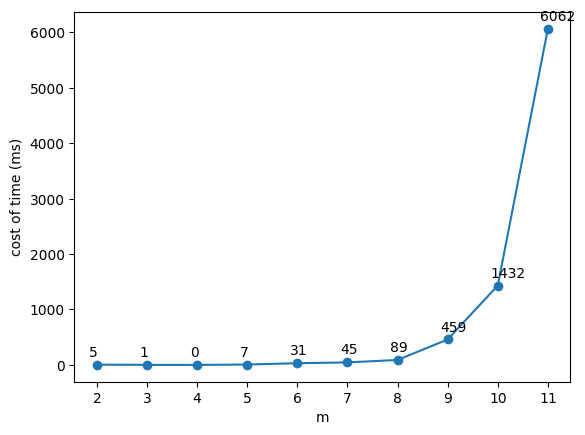

In [91]:
range_list = list(range(2, 12))
time_list = []

for r in range_list:
    start = time.time()
    C_mat = generate_C(r)
    # pretty_print(C_mat.astype(int))
    X_C = funcX(C_mat)
    n = C_mat.shape[0]
    # expon, o_1 = get_o_1(X_C, n)
    end = time.time()
    time_list.append((end - start) * 1000)
    print("r = {r_term}, n = {n_term}, χ(C) = {X_C_term}"
          .format(r_term=r, n_term=n, X_C_term=X_C))
# latex_matrix(C_mat)

plt.plot(range_list, time_list, marker='o')
plt.xlabel("m")
plt.xticks(range_list)
plt.ylabel("cost of time (ms)")
for x, y in zip(range_list, time_list): 
    plt.text(x-0.15, y + 150, "%.0f" % y)
plt.show()

In [5]:
i = 5309014126942371.0
scientific_notation="{:e}".format(i)
print(scientific_notation)

5.309014e+15
